<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/Copy_of_Unit7ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting Curves: Concepts

What you'll do:

- Answer questions about what a GP is, and its relationship to GLMs and splines.
- Practice applying one of: polynomial modeling, b splines, or GPs
- You'll get a chance to read about and try to comprehend a more standard implementation of a GP.

Have fun!

**Task1**:

Why would you ever want to include a polynomial element in a model you built? What's the benefit of using polynomials to model?

Polynomials can curve in ways that a generalized linear model cannot, which may allow capturing of more complex trends in a dataset.

**Task2**:

Why would you ever NOT want to include a polynomial element in a model you built?

If the data could be captured equally well by a linear model as by a polynomial model, the simpler linear model would be preferable to prevent overfitting.

**Task3**:

What's the point of using b splines?

B splines help mitigate overfitting in polynomial models while still being able to access the power of polynomial curves for the different sections of the model.

**Task4**:

Describe what a Gaussian Process is, in your own words. *Don't worry about being correct, just try to explain it to yourself*. I will not grade this question for accuracy.

A Gaussian Process is a spline where, ideally, there are infinite knots, or, in reality, every data point is a knot. This allows a model to focus in on the predictive effects of every data point.

**Task5**:

Refit a model to the howell data, using one of the following: polynomial model, b splines, or GPs.
Plot the posterior predictive check on a scatter plot

You only need to use one . Remember, the simpler the model is, the better (usually).

Hint: If you use a polynomial or bspline, try a disdributional model


In [1]:
!pip install preliz
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.1/517.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-15dz5wx0
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-15dz5wx0
  Resolved https://github.com/pydata/xarray.git to commit 4bbab48cacf94ff285475bd7b7abeea3b2ea888f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev16+g4bbab48c-py3-none-any.whl size=1255523 sha256=3aa1b241adcd52f271789b1714e0ef7dc91217ed514e0c0381ef8b10f9d88b50
  Stored

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
import preliz as pz

In [3]:
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/howell.csv')

In [21]:
#One degree model
varying_1 = bmb.Formula("weight ~ height", "sigma ~ height")
model_1 = bmb.Model(varying_1, howell)
idata_1 = model_1.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


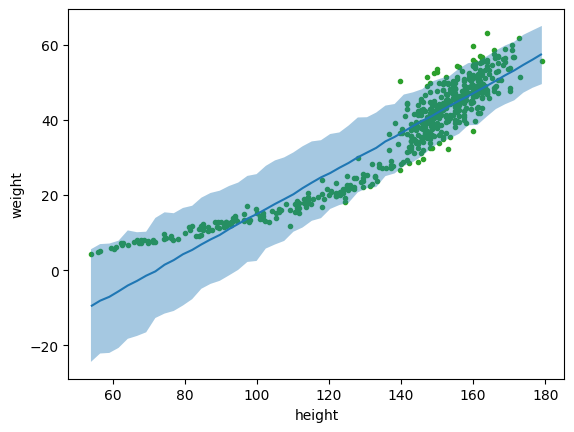

In [22]:
bmb.interpret.plot_predictions(model_1, idata_1, "height", pps=True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


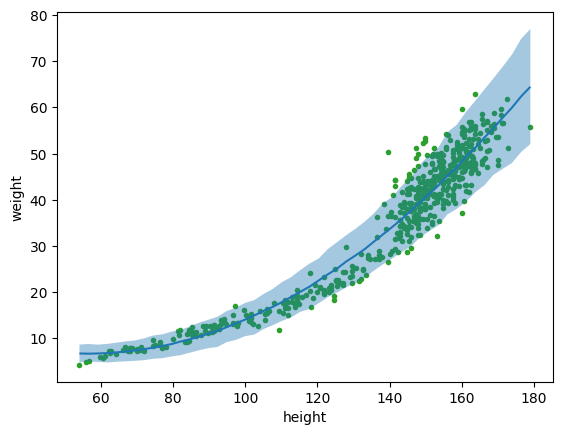

In [20]:
#Two degree model
varying_2 = bmb.Formula("weight ~ poly(height, 2)", "sigma ~ height")
model_2 = bmb.Model(varying_2, howell)
idata_2 = model_2.fit()
bmb.interpret.plot_predictions(model_2, idata_2, "height", pps=True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


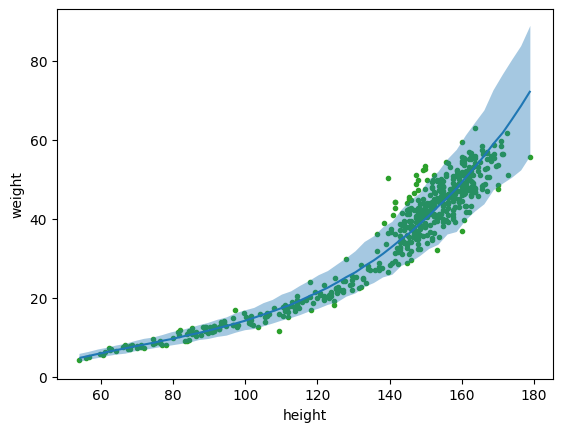

In [23]:
#Three degree model
varying_3 = bmb.Formula("weight ~ poly(height, 3)", "sigma ~ height")
model_3 = bmb.Model(varying_3, howell)
idata_3 = model_3.fit()
bmb.interpret.plot_predictions(model_3, idata_3, "height", pps=True)
plt.plot(howell.height, howell.weight, "C2.", zorder=-3)

In [6]:
#convert from pandas to numpy array
weight = howell["weight"].values
height = howell["height"].values

In [7]:
#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [8]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(weight))
}

priors = {
    "hsgp(weight, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("height ~ 0 + hsgp(weight, m=10, c=1.5)", howell, family="negativebinomial", priors=priors)
idata_hsb = model_hsb.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


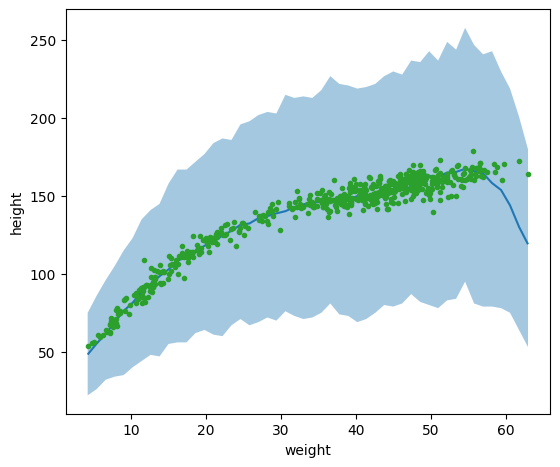

In [10]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["weight"],
                                       pps = True,
                                       fig_kwargs={"figsize": (6.25, 5.25)})
ax[0].plot(howell["weight"].values, howell["height"].values, "C2.")

The second degree polynomial does better than the one degree model, but the third degree polynomial does not do better than the simpler second degree one, so the second degree model is the best choice choice. The HSGP model is much more uncertain about the trend, so it should not be used over the second degree polynomial model.

**Task6**:

Read the article on the pymc website about GP implementation on the Mauna Loa CO$_{2}$ data combined with CO$_{2}$ ice core data from the south pole.
[Link here.](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa2.html)

Write down one thing you learned about GPs from reading the article.

Note: You probably won't understand anything in this article. The main point of this task is to hammer home that good GP implementations are extremely technical.

The lengthscale for a GP helps control the smoothness of the curve. Higher length values are interpreted as points further from each other being more correlated. You can specify a prior for it if you have information about what it should be.

**Task7**:

Describe your favorite graph from the article in the previous task. Explain why its your favorite.

My favorite graph was the posterior predictive plot because it had a lot of colors, and the white, blue, and black felt like a good choice. A pretty, readable plot is an important aspect of an article like this, especially for audience members who do not fully understand the underlying processes of the predictions. I liked watching the variance decrease as the model was iterated on until the predictions were all really close to the data.